In [1]:
import sys
import os
sys.path.append(os.path.join('..'))
from analysis.eval_model_helpers import *
from models.func_to_func2d_invasive import FNO2d
from util.utilities_module import *
from gen_GRF import *
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle as pkl


In [2]:
def gaussian_random_field_grad(s,size):
    """ 
    Generate a 2D  Gaussian Random Field and its gradient
    """
    # generate the same field for all sizes

    d=2

    alpha = s + d/2

    # Defines momentum indices
    ks_x = torch.fft.fftfreq(size,d = 1/size)
    ks_y = torch.fft.rfftfreq(size,d = 1/size)
    ks_x_2d, ks_y_2d = torch.meshgrid(ks_x, ks_y, indexing = 'ij')

    
    lambda_k = (ks_x_2d**2 + ks_y_2d**2 + 1)**(-alpha/2)

    noise_re, noise_im = torch.randn(2,*lambda_k.shape)
    xi_noise = noise_re + 1j*noise_im
    u_ft2 = xi_noise*lambda_k
    gfield = torch.fft.irfft2(u_ft2,norm = 'forward')

    # compute the gradient
    u_ft2_dx = 2*np.pi*1j*ks_x_2d*u_ft2
    u_ft2_dy = 2*np.pi*1j*ks_y_2d*u_ft2

    gfield_dx = torch.fft.irfft2(u_ft2_dx,norm = 'forward')
    gfield_dy = torch.fft.irfft2(u_ft2_dy,norm = 'forward')

    return gfield, gfield_dx, gfield_dy

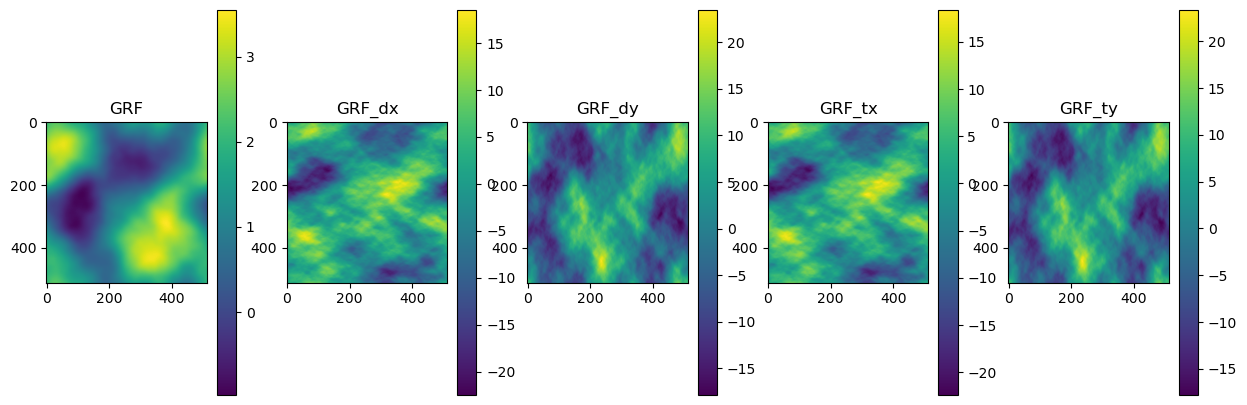

In [3]:
# Generate data (GRF inputs)
s = 2
# set torch seed
size = 512
torch.manual_seed(1989)
# process input arguments
sample_count = 10
input_data = torch.zeros(sample_count,1,size,size)
output_data = torch.zeros(sample_count,2,size,size)

for n in range(sample_count):
    gfield, gfield_dx, gfield_dy = gaussian_random_field_grad(s,size)
    input = gfield
    output = torch.stack([gfield_dx,gfield_dy],axis = 0)
    input_data[n] = input
    output_data[n] = output
print(gfield.shape)
print(gfield_dx.shape)
# save the data
torch.save(input_data,'grad_training_data/input_data_grad.pt')
torch.save(output_data,'grad_training_data/output_data_grad.pt')


# take gradient with torch
gfield_tx, gfield_ty = torch.gradient(gfield,spacing = 1/size)
    
# plot the generated GRF
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax0 = ax[0].imshow(gfield, cmap='viridis')
plt.colorbar(ax0, ax=ax[0])
ax[0].set_title('GRF')
ax1 = ax[1].imshow(gfield_dx, cmap='viridis')
plt.colorbar(ax1, ax=ax[1])
ax[1].set_title('GRF_dx')
ax2 = ax[2].imshow(gfield_dy, cmap='viridis')
plt.colorbar(ax2, ax=ax[2])
ax[2].set_title('GRF_dy')

ax3 = ax[3].imshow(gfield_tx, cmap='viridis')
plt.colorbar(ax3, ax=ax[3])
ax[3].set_title('GRF_tx')
ax4 = ax[4].imshow(gfield_ty, cmap='viridis')
plt.colorbar(ax4, ax=ax[4])
ax[4].set_title('GRF_ty')


plt.show()
